#Time Serial Analysis to determine the annual incidences of diseases in Mexico from 2016 to 2019 and forecasting from 2020 to 2023

##Introduction
In 2000 industry leaders developed a freely available data mining model called CRoss-Industry Standard Process for Data Mining (crisp-dm).
This model aims to improve best practices and provides an organized structure for faster and better data mining results.[1]
CRISP-DM organizes the data mining process in six phases:
* Business understanding: Understand the problem to solve and how the solution generate revenues to the business
* Data understanding: Know the available data, what can be mining from them or which was their original purpose and how to adapt it to the new purpose
* Data preparation: Implies all the transformations done to the raw data to became it worthwhile for the models
* Modeling: All the models conducted to respond and make a solution for the problem
* Evaluation: Evaluate qualitative and quantitative the performance and accuracy of the model.
* Deployment: Present the possible revenues that the model offers, and if it is possible, check if this estimation at least is equal to the true considering profitable or is lower interpreting an inefficient 


Key Words:data analytics, data mining, time series, crisp-dm, clustering, prophet, forecasting

##Business Understanding
The World Health Organization (WHO) promotes the recommendation that countries should invest at least between 6% and 8% of their gross domestic product (GDP) in public spending on health. According to the OECD, member countries spend on average 5.7% of public spending, reaching a level higher than 8% in France (8.8), the USA (8.5), and Germany (8.1)[2,3]. On average, the Mexican State has allocated around 3% of GDP as public spending on health. 

The federal general budget approved for the Health function in Mexico was 653 thousand 443.15 million pesos (MMDP) for 2020, representing an increase of 4.35% compared to the one approved in 2019.[4] Therefore, the approved expenditure for this function was equivalent to 2.49% of GDP. Finally, according to CONAMED, 39% of family spending is spent on medicines.

Due to this lack of budget, it is helpful to analyze the morbidities that most affect the Mexican population and allocate the budget to reduce their incidence, if possible, even to avoid them. Thus, to increase the quality of life of Mexicans and avoid wasting resources in trying to cure preventing diseases.Furthermore, to allow the generation of policies that will enable a reorganization of public spending for non-preventable conditions and reduce the family spending of Mexicans for medicines and care that the state can not provide.



##Data Understanding
The Epidemiological Bulletin, National Epidemiological Surveillance System, is the official media of disseminating morbidity of the National Epidemiological Surveillance System (SINAVE).

This document has been published since 1880 and fulfills the function of disseminating new cases of 146 diseases subject to weekly or annual surveillance by sex, age group, and state [5].

Five bulletins were retrived from the SINAVE, those that corresponde to each year form 2016 to 2019 in pdf format and convert to csv file to retrived the data [8].
Every bulletin is composed of fourteen columns. These are the name of the diseases, the code for identifying them, the total count of incidences in the year, and one column for each month with the monthly incidences. The rows are the counts of each disease, and their number is variable since the relevant causes of morbidity change across the time adding or deleting rows. Likewise, the name and the listed order can change between years. 

In [ ]:
#First Install Packages
# https://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas
!pip3 install seaborn==0.9.0
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fbprophet import Prophet
plt.style.use('bmh')
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

     |████████████████████████████████| 215kB 7.5MB/s 
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Data Prepatation
Then the five datasets are merged in one database, for this was required some steps. 

First, each dataset must contain homogenized data to join them. The diseases are sorted in the same row for each list to make them homogeneous. If they are in another position, they are moved to the correct place. Likewise, if the disease does not exist in a previous year, a lower value is input to this year. 

Suppose they have a similar but not equal name, the name changes to the latest one, which can only be applied when the code is the same. Finally, if the disease does not exist more in the recent data, this row is discarded.

Once the information is joinable, it is merged in adjacent columns to generate the time series for each row and overwrite the heads to assign the correct format to detect as dates in python.

After reading the complete file with the five years, it seems that it has two empty rows, dropping with the null command. After it, the code column, since it is not helpful for the model, was removed. At the final, the disease column became the index. 

To present the data since it is numeric, but the diseases are in the index, the transpose matrix generates the data's description to estimate the mean, standard deviation, and other parameters. These incidences for each disease are monthly since each row represents the count of a month.

In [ ]:
#Read data
data=pd.read_csv("diseases.csv")
data

,disease,code,01/01/2016,01/02/2016,01/03/2016,01/04/2016,01/05/2016,01/06/2016,01/07/2016,01/08/2016,01/09/2016,01/10/2016,01/11/2016,01/12/2016,01/01/2017,01/02/2017,01/03/2017,01/04/2017,01/05/2017,01/06/2017,01/07/2017,01/08/2017,01/09/2017,01/10/2017,01/11/2017,01/12/2017,01/01/2018,01/02/2018,01/03/2018,01/04/2018,01/05/2018,01/06/2018,01/07/2018,01/08/2018,01/09/2018,01/10/2018,01/11/2018,01/12/2018,01/01/2019,01/02/2019,01/03/2019,01/04/2019,01/05/2019,01/06/2019,01/07/2019,01/08/2019,01/09/2019,01/10/2019,01/11/2019,01/12/2019
0,Absceso hepático amebiano,A06.4,46.0,50.0,48.0,39.0,40.0,44.0,58.0,51.0,73.0,49.0,33.0,29.0,35.0,76.0,54.0,42.0,NaN,39.0,40.0,49.0,38.0,46.0,40.0,54.0,35.0,40.0,37.0,40.0,60.0,42.0,39.0,57.0,36.0,68.0,47.0,44.0,78.0,47.0,58.0,45.0,79.0,67.0,60.0,80.0,49.0,150.0,53.0,48.0
1,Accidentes de transporte en vehículos con motor,"V20-V29, V40-V79",9397.0,9382.0,11935.0,9715.0,10929.0,12915.0,9478.0,11280.0,9665.0,9044.0,11686.0,9165.0,8649.0,9021.0,10911.0,9448.0,11066.0,9170.0,8356.0,11305.0,8946.0,9777.0,12021.0,8769.0,10659.0,10180.0,10009.0,9631.0,12358.0,10309.0,9488.0,12660.0,10644.0,13119.0,10208.0,8999.0,11555.0,10234.0,10822.0,10334.0,13209.0,10671.0,12271.0,10796.0,11357.0,13446.0,10811.0,10312.0
2,Amebiasis intestinal,"A06.0-A06.3, A06.9",15806.0,16269.0,19446.0,20070.0,20369.0,25882.0,19450.0,22895.0,17170.0,16375.0,16578.0,9895.0,16816.0,18184.0,24088.0,17121.0,23903.0,21714.0,19415.0,23080.0,16910.0,16901.0,18691.0,10586.0,16776.0,15106.0,15660.0,17913.0,22988.0,19301.0,17100.0,21527.0,16195.0,18458.0,12891.0,9259.0,15264.0,14326.0,15061.0,13635.0,19249.0,17570.0,20635.0,16347.0,14918.0,19609.0,14301.0,10522.0
3,Anencefalia,Q00,23.0,24.0,24.0,28.0,27.0,35.0,27.0,28.0,26.0,33.0,14.0,12.0,18.0,27.0,36.0,16.0,28.0,24.0,17.0,16.0,26.0,24.0,15.0,15.0,23.0,19.0,30.0,28.0,27.0,20.0,25.0,21.0,20.0,17.0,17.0,21.0,20.0,13.0,16.0,8.0,14.0,18.0,22.0,15.0,11.0,16.0,16.0,19.0
4,"Anorexia, bulimia y otros trastornos alimentarios",F50,157.0,205.0,163.0,202.0,219.0,228.0,206.0,280.0,205.0,173.0,227.0,110.0,191.0,171.0,304.0,241.0,282.0,264.0,241.0,306.0,210.0,234.0,311.0,131.0,210.0,222.0,176.0,215.0,303.0,283.0,261.0,294.0,275.0,291.0,230.0,182.0,307.0,249.0,288.0,217.0,357.0,301.0,316.0,239.0,224.0,401.0,260.0,185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,Varicela,B01,13125.0,16239.0,21515.0,16893.0,16215.0,17651.0,9694.0,8929.0,7581.0,8843.0,12050.0,9127.0,13548.0,16472.0,26062.0,17070.0,19705.0,12908.0,8722.0,7941.0,6486.0,6815.0,9751.0,8116.0,14258.0,14108.0,14453.0,13855.0,16722.0,11334.0,7506.0,6582.0,6456.0,9661.0,8331.0,7130.0,12188.0,12180.0,13823.0,12037.0,14315.0,8926.0,7120.0,4712.0,4991.0,7747.0,6956.0,5991.0
144,Violencia intrafamiliar,Y07.0-Y07.2,4035.0,6118.0,8130.0,8264.0,7253.0,9138.0,6976.0,8414.0,7340.0,7529.0,7756.0,4062.0,4225.0,5670.0,8491.0,7023.0,9449.0,8174.0,6832.0,8661.0,7800.0,8762.0,8823.0,4079.0,4988.0,5652.0,5704.0,6631.0,8197.0,6957.0,6551.0,9056.0,8141.0,9534.0,7565.0,4446.0,3866.0,7095.0,8306.0,7144.0,9734.0,8191.0,8082.0,7144.0,7853.0,8802.0,7231.0,4571.0
145,Vulvovaginitis,N76,35903.0,35338.0,42236.0,39983.0,38463.0,52250.0,39898.0,49173.0,38668.0,41615.0,47118.0,29651.0,42946.0,43684.0,58820.0,46427.0,64288.0,55918.0,52802.0,65446.0,52122.0,55239.0,61702.0,36892.0,54823.0,50887.0,46999.0,52780.0,66010.0,54118.0,52190.0,64632.0,54698.0,67846.0,56906.0,37680.0,56321.0,49797.0,51657.0,49001.0,63624.0,53972.0,63965.0,52047.0,50949.0,66103.0,51527.0,39510.0
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Database has the name of the diseases and the code, 
#the code is not relevant so is dropped 
diseases=data.drop(columns = 'code')
#Then rows with null values are eliminate 
diseases = diseases[~diseases.disease.isnull()].copy()
#Display the average incidence by month for each disease
diseases=diseases.set_index('disease')
diseases.T.describe()

disease,Absceso hepático amebiano,Accidentes de transporte en vehículos con motor,Amebiasis intestinal,Anencefalia,"Anorexia, bulimia y otros trastornos alimentarios",Ascariasis,Asma,Bocio endémico,Brucelosis,Candidiasis urogenital,Chancro blando,Cirrosis hepática alcohólica,Cisticercosis,Cólera,Conjuntivitis,Conjuntivitis epidémica aguda hemorrágica,"Contacto traumatico con avispas, avispones y abejas",Dengue con signos de alarma,Dengue grave,Dengue no grave,Depresión,Desnutrición leve,Desnutrición moderada,Desnutrición severa,Diabetes mellitus en el embarazo,Diabetes mellitus Tipo I,Diabetes mellitus Tipo II,Difteria,Displasia cervical leve y moderada,Displasia cervical severa y CaCu in situ,"Edema, proteinuria y transtornos hipertensivos en el embarazo, parto y puerperio",Efectos del calor y de la luz,Encefalitis equina venezolana,Encefalocele,Enfermedad alcohólica del hígado,Enfermedad cerebrovascular,Enfermedad de Alzheimer,Enfermedad de Parkinson,Enfermedad febril exantemática,Enfermedad invasiva por neumococo,...,Otras rickettsiosis,Otras salmonelosis,Paludismo por Plasmodium falciparum,Paludismo por Plasmodium vivax,Parálisis flácida aguda,Parotiditis infecciosa,Peatón lesionado en accidente de transporte,Peste,Poliomielitis aguda,Quemaduras,Rabia humana,Rubéola,Sarampión,Shigelosis,Sífilis adquirida,Sífilis congénita,Síndrome coqueluchoide,Síndrome de inmunodeficiencia adquirida,Síndrome de rubéola congénita,Síndrome Meníngeo,Teniasis,Tétanos,Tétanos neonatal,Tifo epidémico,Tifo murino,Tos ferina,Toxoplasmosis,Tracoma,Tricomoniasis urogenital,Tripanosomiasis americana aguda (Enfermedad deChagas),Tripanosomiasis americana crónica (Enfermedad de Chagas),Triquinosis,Tuberculosis otras formas,Tuberculosis respiratoria,Tumor maligno de la mama,Tumor maligno del cuello del útero,"Úlceras, gastritis y duodenitis",Varicela,Violencia intrafamiliar,Vulvovaginitis
count,47.000000,48.000000,48.000000,48.000000,48.00000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.00000,48.000000,48.000000,48.000000,48.00000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.0,48.000000,48.000000,48.000000,48.000000,48.0,48.000000,48.000000,48.00000,48.000000,48.000000,48.000000,48.000000,...,48.000000,48.000000,48.0,48.000000,48.000000,48.000000,48.000000,48.0,48.0,48.000000,48.0,48.0,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.0,48.000000,48.00000,48.000000,48.000000,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,51.744681,10544.000000,17546.354167,21.229167,240.56250,3599.125000,21239.666667,83.104167,147.812500,15028.187500,52.145833,699.18750,16.666667,0.041667,92574.437500,49.06250,989.750000,361.208333,178.458333,5120.604167,9876.208333,6473.833333,1008.270833,474.104167,1067.270833,450.541667,34219.666667,0.0,3184.020833,403.395833,5409.395833,298.041667,0.0,5.937500,558.166667,3613.68750,246.250000,693.479167,347.416667,2.541667,...,13.291667,6836.104167,0.0,56.416667,58.000000,526.250000,2032.104167,0.0,0.0,9396.333333,0.0,0.0,0.0,309.708333,451.791667,17.875000,150.083333,494.916667,0.0,5588.875000,15.31250,9.500000,0.729167,0.0,12.479167,73.187500,12.395833,0.229167,2711.625000,27.750000,52.833333,1.104167,340.354167,1486.791667,1101.416667,275.354167,119274.270833,11517.500000,7175.937500,50721.333333
std,19.480724,1322.214632,3706.384868,6.385621,58.34815,751.028674,4369.430779,24.052460,55.652668,2399.165064,15.079914,212.86702,5.462964,0.201941,31592.646286,154.91266,323.717075,557.364847,211.048140,7518.879995,1554.690268,1342.580594,209.416590,98.679416,529.495173,332.041971,5243.040069,0.0,588.869580,91.278097,710.756347,215.645094,0.0,2.461674,112.484956,558.68585,41.785929,102.456631,155.050278,2.767273,...,7.643544,1415.817548,0.0,29.058879,19.091047,223.097679,356.635474,0.0,0.0,1277.333348,0.0,0.0,0.0,94.482230

After the first exploratory analysis of the data, since the database has 146 diseases to reduce and select relevant conditions, they were clustered with linkage applying ward method and Euclidean distance.  Diseases with less than 50 incidences in the first month of the last year are discarded to avoid null or infinite values and then plot them to visualize data and check their behavior.

In [ ]:
#The clusters estimate differences between them with the euclidian distance, 
#distances between months need to be significant to avoid null  or infinite 
#values, so diseases with less than 50 incidences in the first month of the
#last year are discarded
diseases = diseases[diseases['01/12/2019'] > 50]
diseases


,01/01/2016,01/02/2016,01/03/2016,01/04/2016,01/05/2016,01/06/2016,01/07/2016,01/08/2016,01/09/2016,01/10/2016,01/11/2016,01/12/2016,01/01/2017,01/02/2017,01/03/2017,01/04/2017,01/05/2017,01/06/2017,01/07/2017,01/08/2017,01/09/2017,01/10/2017,01/11/2017,01/12/2017,01/01/2018,01/02/2018,01/03/2018,01/04/2018,01/05/2018,01/06/2018,01/07/2018,01/08/2018,01/09/2018,01/10/2018,01/11/2018,01/12/2018,01/01/2019,01/02/2019,01/03/2019,01/04/2019,01/05/2019,01/06/2019,01/07/2019,01/08/2019,01/09/2019,01/10/2019,01/11/2019,01/12/2019
disease,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Accidentes de transporte en vehículos con motor,9397.0,9382.0,11935.0,9715.0,10929.0,12915.0,9478.0,11280.0,9665.0,9044.0,11686.0,9165.0,8649.0,9021.0,10911.0,9448.0,11066.0,9170.0,8356.0,11305.0,8946.0,9777.0,12021.0,8769.0,10659.0,10180.0,10009.0,9631.0,12358.0,10309.0,9488.0,12660.0,10644.0,13119.0,10208.0,8999.0,11555.0,10234.0,10822.0,10334.0,13209.0,10671.0,12271.0,10796.0,11357.0,13446.0,10811.0,10312.0
Amebiasis intestinal,15806.0,16269.0,19446.0,20070.0,20369.0,25882.0,19450.0,22895.0,17170.0,16375.0,16578.0,9895.0,16816.0,18184.0,24088.0,17121.0,23903.0,21714.0,19415.0,23080.0,16910.0,16901.0,18691.0,10586.0,16776.0,15106.0,15660.0,17913.0,22988.0,19301.0,17100.0,21527.0,16195.0,18458.0,12891.0,9259.0,15264.0,14326.0,15061.0,13635.0,19249.0,17570.0,20635.0,16347.0,14918.0,19609.0,14301.0,10522.0
"Anorexia, bulimia y otros trastornos alimentarios",157.0,205.0,163.0,202.0,219.0,228.0,206.0,280.0,205.0,173.0,227.0,110.0,191.0,171.0,304.0,241.0,282.0,264.0,241.0,306.0,210.0,234.0,311.0,131.0,210.0,222.0,176.0,215.0,303.0,283.0,261.0,294.0,275.0,291.0,230.0,182.0,307.0,249.0,288.0,217.0,357.0,301.0,316.0,239.0,224.0,401.0,260.0,185.0
Ascariasis,3175.0,3653.0,4127.0,4114.0,3860.0,4692.0,3313.0,4321.0,3124.0,3373.0,3249.0,1689.0,3663.0,4421.0,5553.0,3746.0,4510.0,4115.0,3766.0,4570.0,3397.0,3367.0,3572.0,1984.0,3477.0,3598.0,3144.0,3658.0,4421.0,3549.0,3498.0,4444.0,3754.0,4167.0,2706.0,1759.0,3467.0,3387.0,3539.0,3173.0,4293.0,3807.0,4111.0,3377.0,3284.0,3864.0,3007.0,1920.0
Asma,23264.0,24802.0,23831.0,20007.0,17048.0,19574.0,14622.0,20655.0,23628.0,22782.0,28376.0,20942.0,24588.0,24203.0,27129.0,17196.0,20765.0,15933.0,14787.0,20092.0,23182.0,22722.0,30408.0,22197.0,27946.0,20598.0,19104.0,17499.0,19320.0,14217.0,13998.0,17602.0,20521.0,26384.0,23406.0,21463.0,29988.0,23822.0,22214.0,18526.0,20042.0,14866.0,16162.0,13244.0,18159.0,26667.0,26592.0,24431.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tumor maligno del cuello del útero,241.0,245.0,281.0,278.0,296.0,390.0,321.0,407.0,272.0,273.0,356.0,190.0,193.0,238.0,286.0,225.0,332.0,237.0,220.0,299.0,219.0,202.0,283.0,142.0,243.0,203.0,221.0,242.0,313.0,272.0,282.0,340.0,259.0,406.0,313.0,218.0,270.0,306.0,272.0,317.0,374.0,263.0,357.0,274.0,222.0,304.0,264.0,256.0
"Úlceras, gastritis y duodenitis",102862.0,101511.0,121832.0,114480.0,109920.0,144195.0,107122.0,131533.0,101526.0,104735.0,117676.0,80170.0,116860.0,121118.0,154236.0,115287.0,154247.0,128626.0,121035.0,145864.0,114591.0,119047.0,136814.0,93213.0,133151.0,111863.0,107298.0,122840.0,147577.0,120010.0,112383.0,143322.0,117091.0,140520.0,104726.0,87648.0,132240.0,111342.0,113118.0,108603.0,143455.0,119790.0,140592.0,108974.0,108004.0,138716.0,104452.0,88950.0
Varicela,13125.0,16239.0,21515.0,16893.0,16215.0,17651.0,9694.0,8929.0,7581.0,8843.0,12050.0,9127.0,13548.0,16472.0,26062.0,17070.0,19705.0,12908.0,8722.0,7941.0,6486.0,6815.0,9751.0,8116.0,14258.0,14108.0,14453.0,13855.0,16722.0,11334.0,7506.0,6582.0,6456.0,9661.0,8331.0,7130.0,12188.0,12180.0,13823.0,12037.0,14315.0,8926.0,7120.0,4712.0,4991.0,7747.0,6956.0,5991.0


##Modeling
Next, a brief explanation of the methodology is present. The first model is the clustering of the database to found common patterns in the time series. Two main strategies apply to suggest the optimal number of clusters. A dendrogram is plotted to indicate as the first approach the number of groups then is corrected, generating the most number of sets with more than one disease to be helpful. After creating the clusters, select the most important of them to model with the time series analysis to extract the seasonality and the trend to develop the forecasting of each disease in the selected clusters.

/usr/local/lib/python3.7/dist-packages/seaborn/timeseries.py:183: UserWarning:

The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.



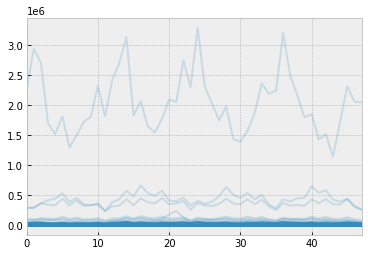

In [ ]:
ax = None
    # seaborn is used to plot the data to check the behaviour across the time
    # tsplot function only exist in seaborn 9 after it was depracated
ax = sns.tsplot(ax=ax, data=diseases.values, err_style="unit_traces")

In [ ]:
# Clustering with Linkage method Ward
Z = hac.linkage(diseases, method='ward', metric='euclidean')

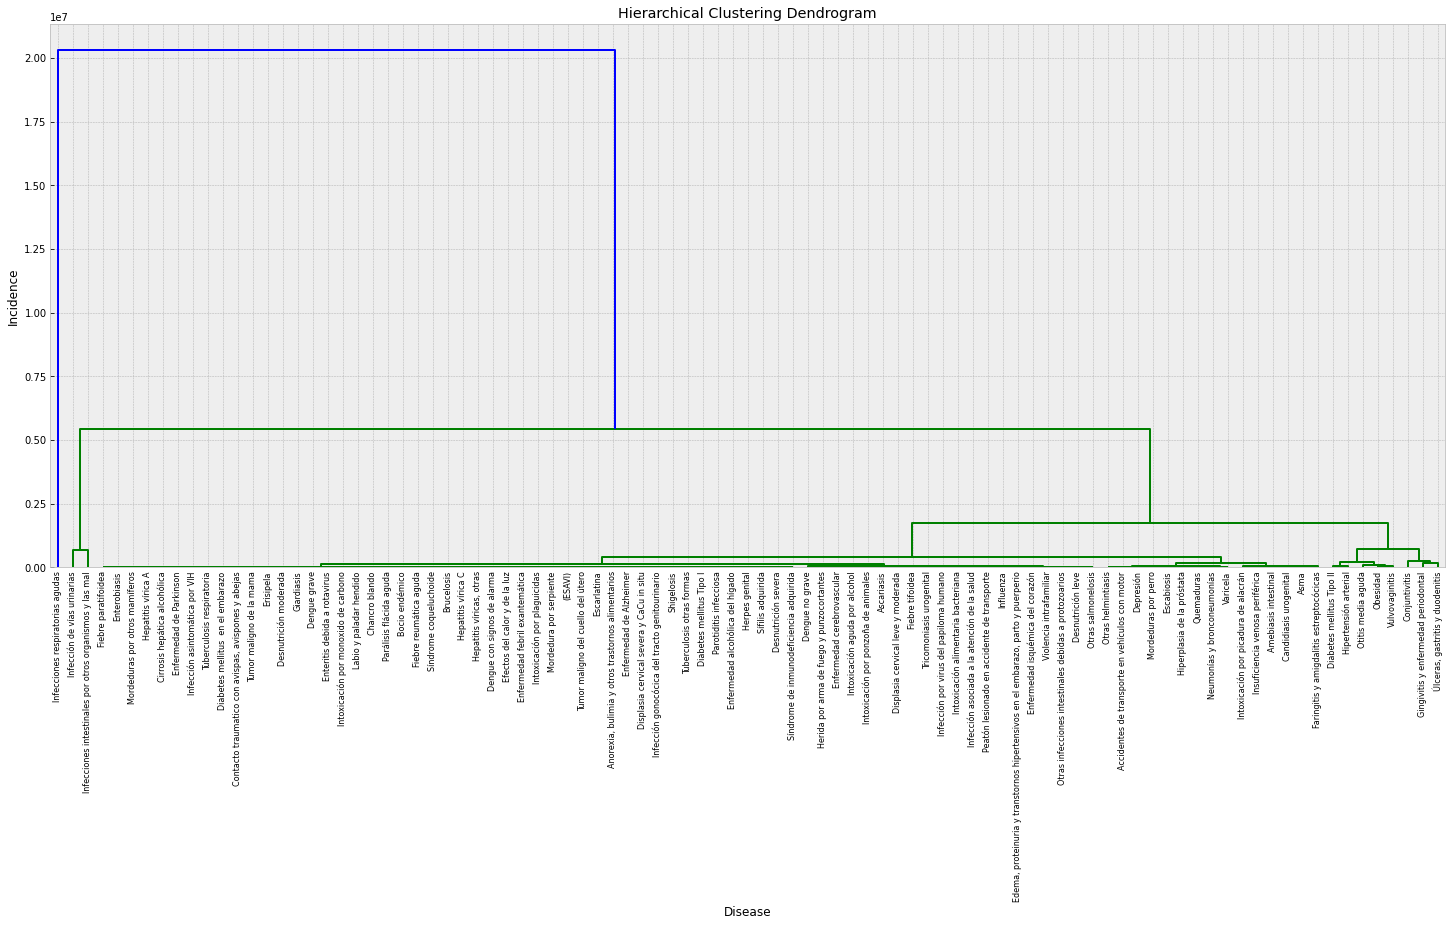

In [ ]:
# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Disease')
plt.ylabel('Incidence')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels=diseases.index
)
plt.show()

The first plot and the dendrogram suggest that the optimal number of clusters is around seven, trying to avoid that one collection will contain most of the diseases, shown in the plot as a solid blue line at the bottom. On the other hand, respiratory infections, because of the high incidence and seasonality in winter, cannot be allocated with other diseases in a cluster.

In [ ]:
# Function for printing the distribution of elements in clusters and plotting together the clusters of time series

from scipy.cluster.hierarchy import fcluster

def print_clusters(timeSeries, Z, k, plot=False):
    # k Number of clusters to extract
    results = fcluster(Z, k, criterion='maxclust')
    print(results)

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
        plt.show()


[2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 2 2 2 2 2 2 3 2 2 1 2 2 1 5 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 3]
Cluster 2 number of entries 82


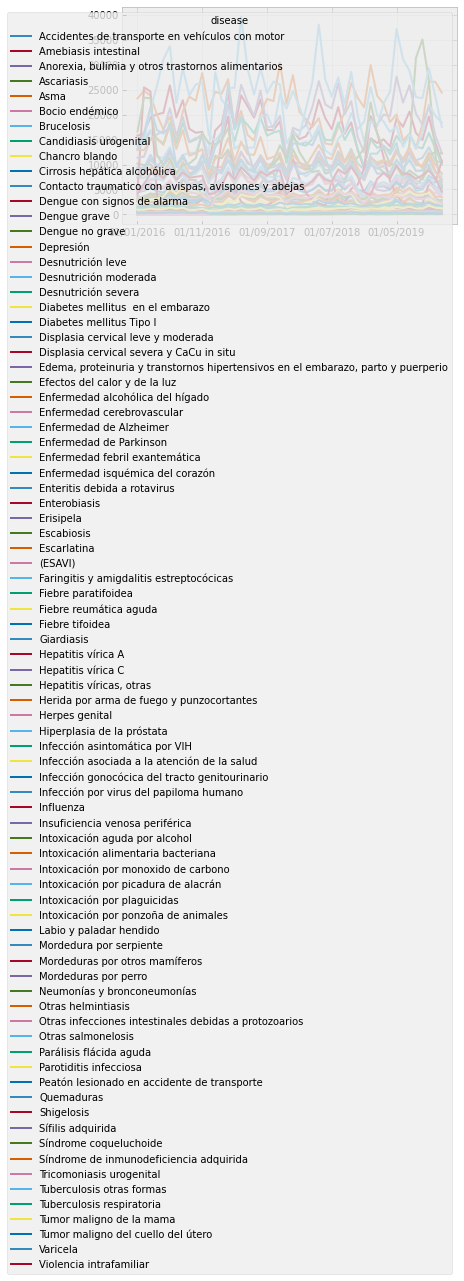

Cluster 4 number of entries 3


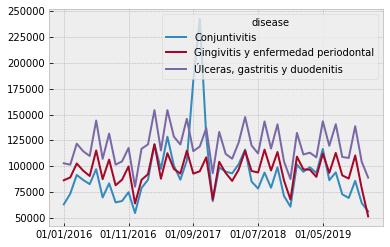

Cluster 3 number of entries 5


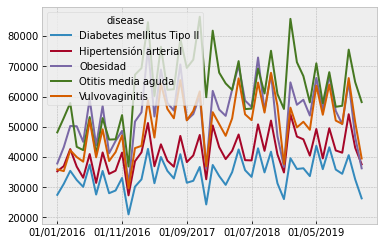

Cluster 1 number of entries 2


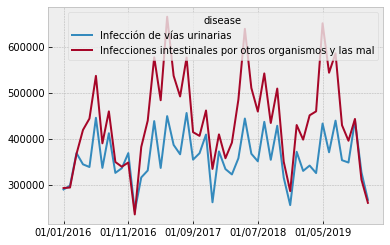

Cluster 5 number of entries 1


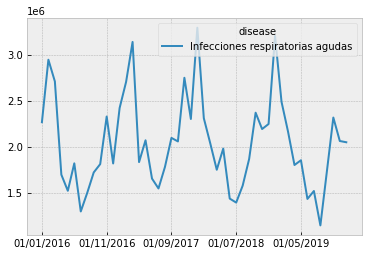

In [ ]:
# Call the function
print_clusters(diseases, Z,5, plot=True)

After suggesting the optimal number of clusters, plot each cluster. As is shown in the dendrogram, respiratory infection incidence is in its cluster isolated. Contrarily seven clusters are not an optimal number since it group three clusters with only one condition. Hence, the following strategy is to increase the number of clusters to split more the data and group them in another way, even though the data is divided and creates more unique clusters. Therefore the number of clusters is reduced to five, in which cluster two has 88% of data with 82 entries, making it impossible to analyze. Once again the cluster five is a unique cluster with only the respiratory infections incidence. Cluster four has the three most common conditions, conjunctivitis, mouth problems, and gastritis. Although they can be prevent required more effort because they are related to environmental pollution, stress, lifestyle, and harmful health behaviors. Cluster one has two diseases associated with the seasonality, both prevalent in summer with high temperatures. Finally, cluster three has five conditions strongly related and relevant for public health. They are comorbidities and joined are called metabolic syndrome (diabetes, obesity, and hypertension) plus two complications: Vulvovaginitis and otitis. Therefore the cluster three is selected to analyzed and generate the forecasting of their diseases. Otitis, since it is a complication of hypertension but is not exclusive, condition is discarded. Vulvovaginitis is keeping, according to Ventolini, G [6], obesity is strongly correlated, and it is also a relevant problem.

In [ ]:
#Selecting data for the most relevant cluster which is the metabolic syndrome 
#and adjusted to generate the forcasting with facebook prophet.
diabetes = diseases.loc['Diabetes mellitus Tipo II']
obesity = diseases.loc['Obesidad']
hypertension = diseases.loc['Hipertensión arterial']
vulvovaginitis = diseases.loc['Vulvovaginitis']
#New Data frame with 4 diseases as columns and 48 dates as rows
metabolic_sydrome = pd.DataFrame({'diabetes':diabetes, 'obesity': obesity,
                                    'hypertension':hypertension, 'vulvovaginitis':vulvovaginitis})
metabolic_sydrome = metabolic_sydrome.reset_index()
metabolic_sydrome.rename(columns={'index': 'date'}, inplace=True)
metabolic_sydrome['date']=pd.to_datetime(metabolic_sydrome.date,dayfirst=True)
metabolic_sydrome

,date,diabetes,obesity,hypertension,vulvovaginitis
0,2016-01-01,27490.0,37858.0,35266.0,35903.0
1,2016-02-01,31114.0,43249.0,36990.0,35338.0
2,2016-03-01,35427.0,50266.0,42614.0,42236.0
3,2016-04-01,32398.0,50176.0,36827.0,39983.0
4,2016-05-01,30133.0,45015.0,33153.0,38463.0
5,2016-06-01,37476.0,59154.0,40976.0,52250.0
6,2016-07-01,27592.0,43820.0,31432.0,39898.0
7,2016-08-01,35396.0,56934.0,41506.0,49173.0
8,2016-09-01,28029.0,41224.0,34425.0,38668.0
9,2016-10-01,28924.0,45291.0,35476.0,41615.0


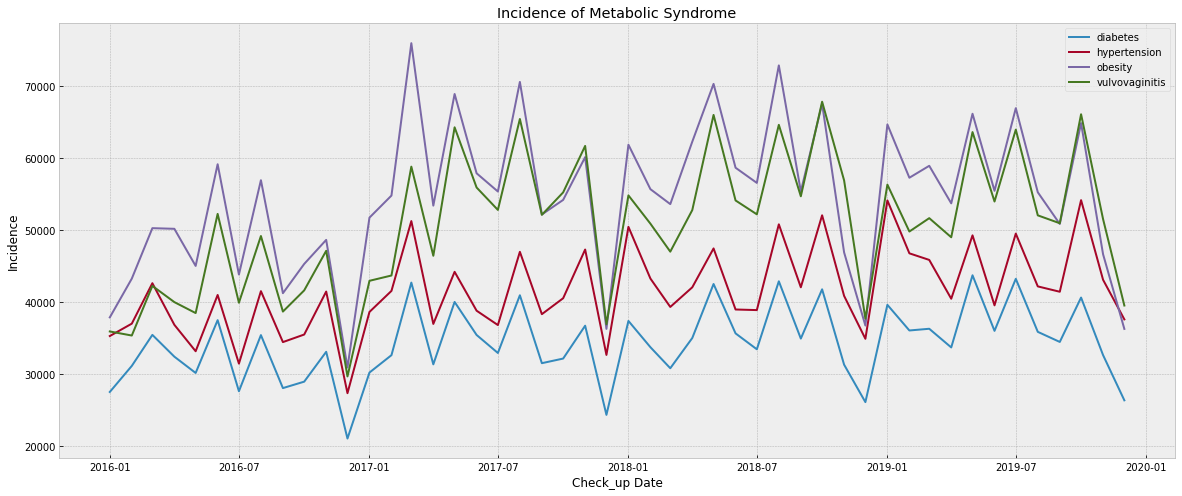

In [ ]:
#Plot of the data frame
plt.figure(figsize=(20, 8))
plt.plot(metabolic_sydrome.date, metabolic_sydrome.diabetes, label = 'diabetes')
plt.plot(metabolic_sydrome.date, metabolic_sydrome.hypertension, label = 'hypertension')
plt.plot(metabolic_sydrome.date, metabolic_sydrome.obesity, label = 'obesity')
plt.plot(metabolic_sydrome.date, metabolic_sydrome.vulvovaginitis, label = 'vulvovaginitis')
plt.xlabel('Check_up Date'); plt.ylabel('Incidence'); plt.title('Incidence of Metabolic Syndrome');
plt.legend()

Decomposition Diabetes 


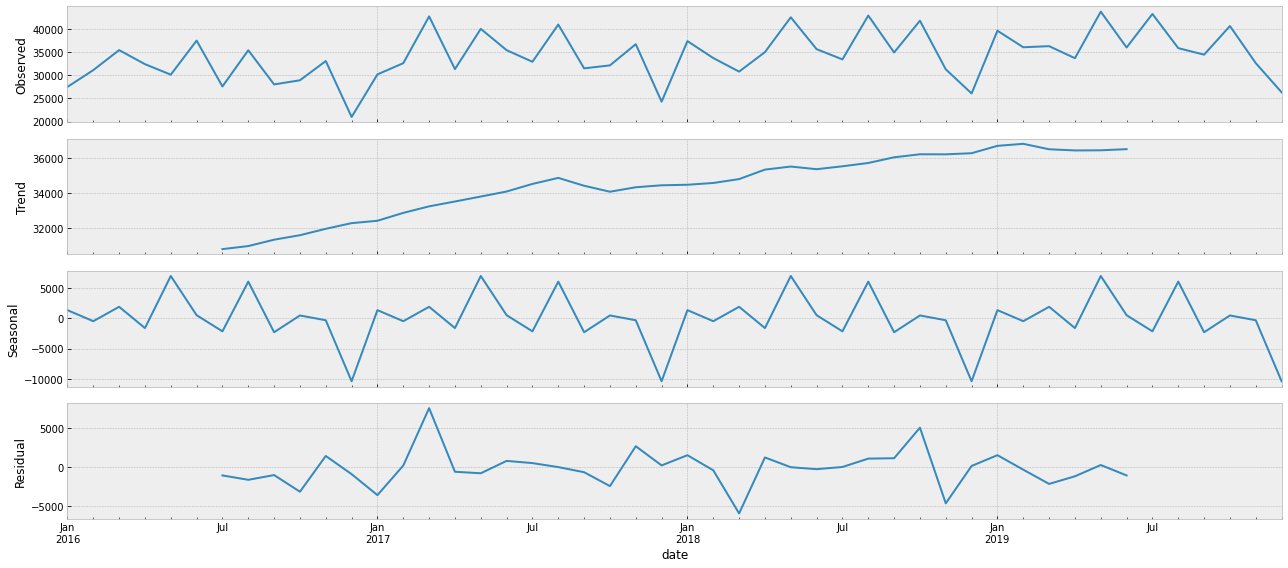

Decomposition Obesity


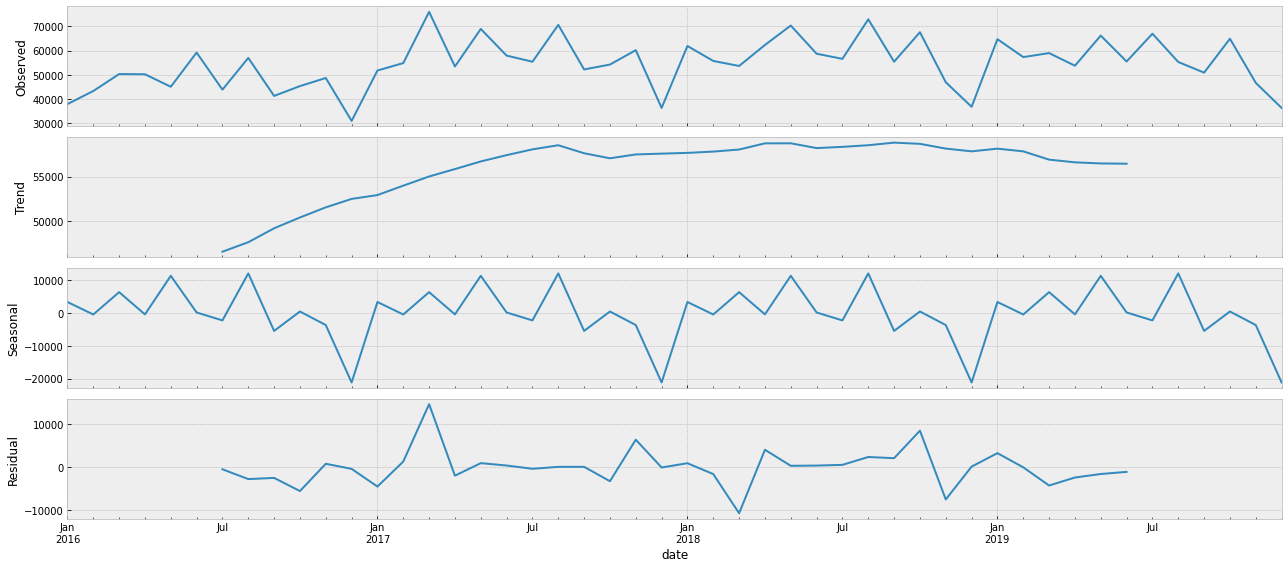

Decomposition Hypertension


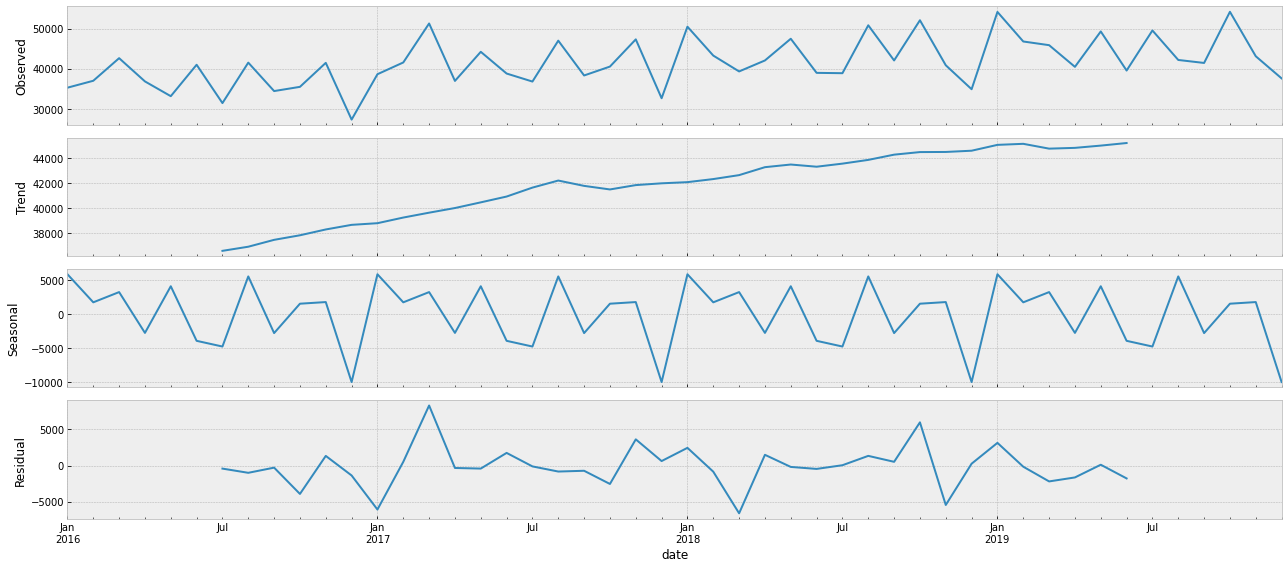

Decomposition Vulvovaginitis


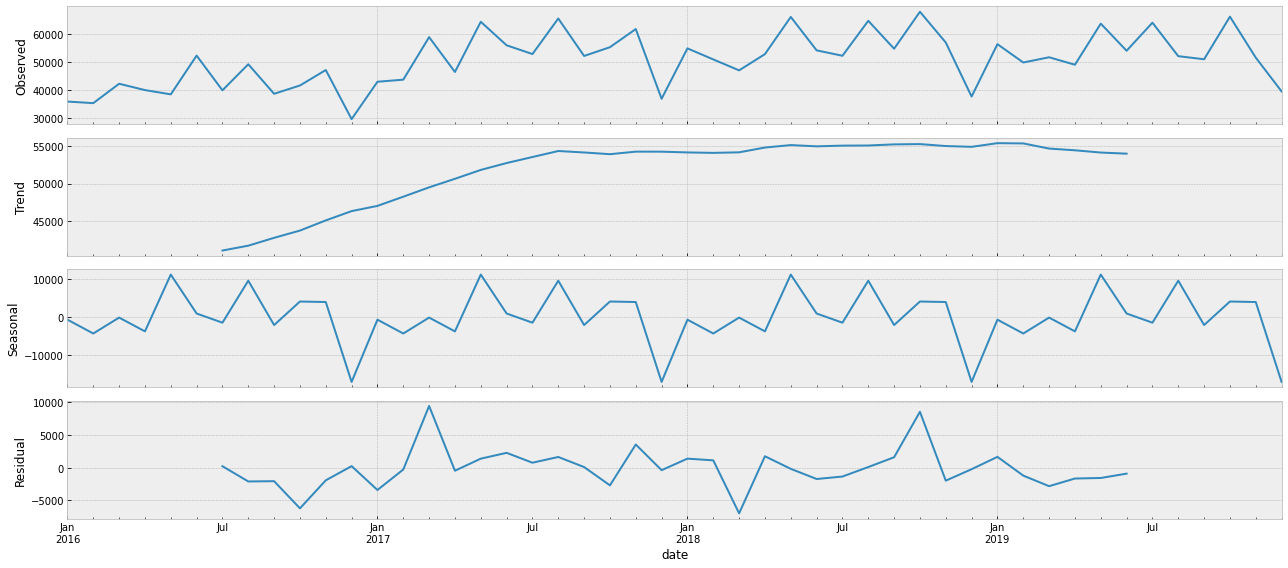

In [ ]:
#Ploting the decomposition of the time series of each disease to find
#the sesonality and trend of the incidence
#Diabetes
y_diabetes =metabolic_sydrome[['date','diabetes']]
diabetes_f= y_diabetes
y_diabetes=y_diabetes.set_index('date')
y_diabetes = y_diabetes.resample('MS').mean()
from pylab import rcParams
print("Decomposition Diabetes ")
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_diabetes, model='additive')
fig = decomposition.plot()
plt.show()

#Obesity
y_obesity =metabolic_sydrome[['date','obesity']]
obesity_f= y_obesity
y_obesity=y_obesity.set_index('date')
y_obesity = y_obesity.resample('MS').mean()
from pylab import rcParams
print("Decomposition Obesity")
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_obesity, model='additive')
fig = decomposition.plot()
plt.show()

#Hypertension
y_hypertension =metabolic_sydrome[['date','hypertension']]
hypertension_f= y_hypertension
y_hypertension=y_hypertension.set_index('date')
y_hypertension = y_hypertension.resample('MS').mean()
from pylab import rcParams
print("Decomposition Hypertension")
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_hypertension, model='additive')
fig = decomposition.plot()
plt.show()

#vulvovaginitis
y_vulvovaginitis =metabolic_sydrome[['date','vulvovaginitis']]
vulvovaginitis_f= y_vulvovaginitis
y_vulvovaginitis=y_vulvovaginitis.set_index('date')
y_vulvovaginitis = y_vulvovaginitis.resample('MS').mean()
from pylab import rcParams
print("Decomposition Vulvovaginitis")
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y_vulvovaginitis, model='additive')
fig = decomposition.plot()
plt.show()

After selecting the cluster, it is plotted to search if exist a notorious behavior to analyze. The plot reveals that it has a trend and a pattern, the trend, as was expected, increases over time and not only for the population growth but also because the number of new cases each year increases. The pattern is not clear but seems to be annual since the last month reduces the number of incidences, and in the first months, it raises to their maximum, visualized as peaks. Decomposition of the time series is conducted to analyze and show the trend and pattern (seasonality) in a better way, splitting them from the original data. The actual data(observed), the trend, the seasonality, and the residuals are plotted for each disease from the decomposition. Related to the shift, which will be graphed together after with Facebook prophet, two trending pairs exist obesity with vulvovaginitis and diabetes with hypertension. The fourth conditions have similarities merging them in the same cluster for the seasonality and their residuals. In the four cases, an annual decrease in December and an annual peak in January will cause a failure in the forecasting since the peak appears as part of the residual and not of the seasonality. The Christmas holidays explained those peaks since most of the people in Mexico celebrate Christmas and forget to go to the doctor for their check-ups. As the incidence is counting with visits to the doctor, it explains the decrease. The peaks have the exact cause, but with an inverse effect due to the holidays and their customs, the illness people without a diagnosis go to the doctors decompensated from their chronic pathologies representing the new cases in the peaks.  

In [ ]:
#Modeling data for forecasting
diabetes_f = diabetes_f.rename(columns={'date': 'ds', 'diabetes': 'y'})
diabetes_model = Prophet(interval_width=0.95)
diabetes_model.fit(diabetes_f)

obesity_f = obesity_f.rename(columns={'date': 'ds', 'obesity': 'y'})
obesity_model = Prophet(interval_width=0.95)
obesity_model.fit(obesity_f)

hypertension_f = hypertension_f.rename(columns={'date': 'ds', 'hypertension': 'y'})
hypertension_model = Prophet(interval_width=0.95)
hypertension_model.fit(hypertension_f)

vulvovaginitis_f = vulvovaginitis_f.rename(columns={'date': 'ds', 'vulvovaginitis': 'y'})
vulvovaginitis_model = Prophet(interval_width=0.95)
vulvovaginitis_model.fit(vulvovaginitis_f)

#Forecasting from 2020 to 2023 for metabolic syndrome with FB Prophet Algorithm
diabetes_forecast = diabetes_model.make_future_dataframe(periods=48, freq='MS')
diabetes_forecast = diabetes_model.predict(diabetes_forecast)

obesity_forecast = obesity_model.make_future_dataframe(periods=48, freq='MS')
obesity_forecast = obesity_model.predict(obesity_forecast)

hypertension_forecast = hypertension_model.make_future_dataframe(periods=48, freq='MS')
hypertension_forecast = hypertension_model.predict(hypertension_forecast)

vulvovaginitis_forecast = vulvovaginitis_model.make_future_dataframe(periods=48, freq='MS')
vulvovaginitis_forecast = vulvovaginitis_model.predict(vulvovaginitis_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


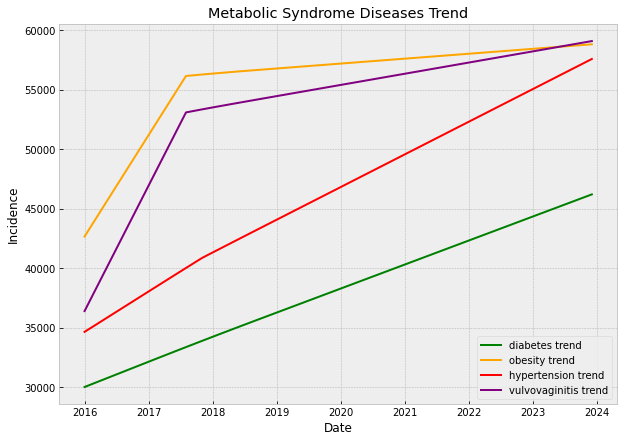

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(diabetes_forecast['ds'], diabetes_forecast['trend'],'g',label = 'diabetes trend' )
plt.plot(obesity_forecast['ds'], obesity_forecast['trend'],'orange',label = 'obesity trend')
plt.plot(hypertension_forecast['ds'], hypertension_forecast['trend'],'red',label = 'hypertension trend')
plt.plot(vulvovaginitis_forecast['ds'], vulvovaginitis_forecast['trend'],'purple',label = 'vulvovaginitis trend')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Incidence')
plt.title('Metabolic Syndrome Diseases Trend');

As was mention before, the trend of the four conditions is to grow up. It seems like linear growth, so they are increasing over time since this is the trend and diabetes and hypertension are incurables implies that the number of cases is rising quickly, generating million of sick. Obesity needs a solid effort to cure. It requires changes in eating habits and increased physical activity[7]. For obesity and vulvovaginitis, from 2016 to 2017, an artificial effect seems to affect the plot, even though the growth behavior. The trend´s difference in the growth rate from 20,000 per month in the first year to 2,500 in the following years is impossible. It can occur when the information was retrieved and change the threshold to consider obesity or become a public health issue after 2017, increasing the efforts to detect obese people. 



##Evaluation
Two parameters apply to evaluate the model. The first parameter is to compare the plot from the predictive values for each disease with the accurate data. For the second parameter, some metrics, such as Mean Square Error(MSE) and Mean Absolute Error (MAE), are estimated with ten-fold cross-validation.

Text(0.5, 1.0, 'Forecasting vs. Real data for vulvovaginitis')

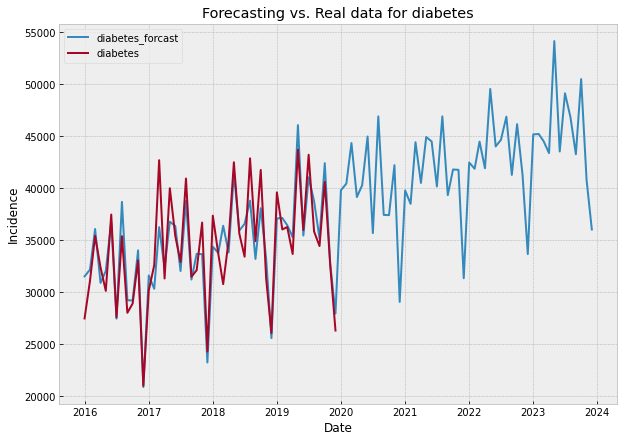

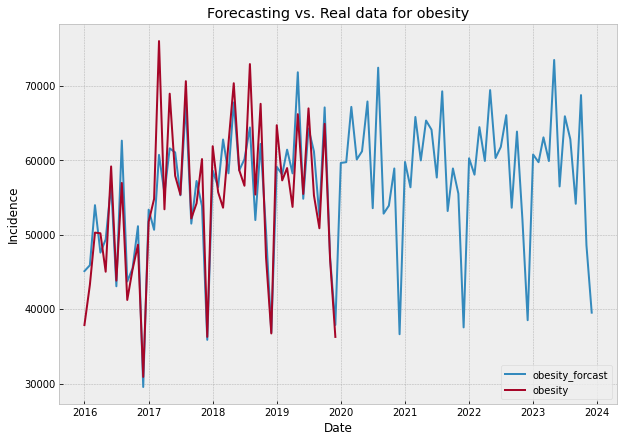

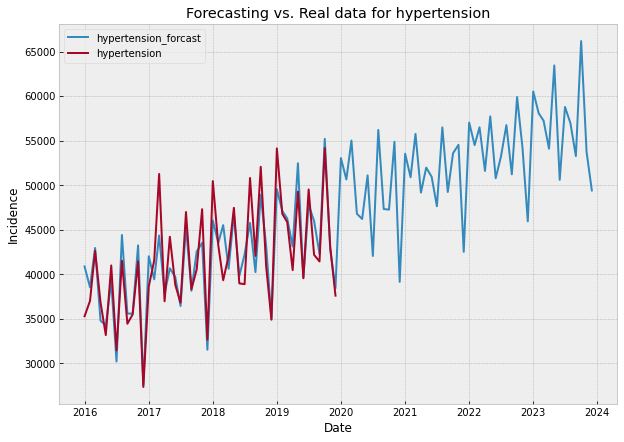

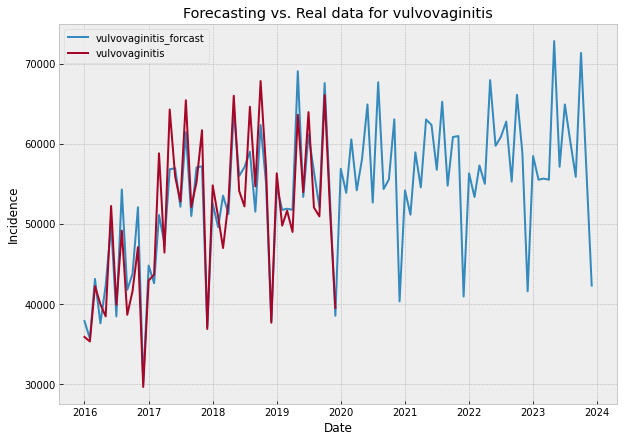

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(diabetes_forecast['ds'], diabetes_forecast['yhat'],label = 'diabetes_forcast');
plt.plot(diabetes_f['ds'], diabetes_f['y'], label = 'diabetes');
plt.legend(); plt.xlabel('Date'); plt.ylabel('Incidence');
plt.title('Forecasting vs. Real data for diabetes')

plt.figure(figsize=(10, 7))
plt.plot(obesity_forecast['ds'], obesity_forecast['yhat'],label = 'obesity_forcast');
plt.plot(obesity_f['ds'], obesity_f['y'], label = 'obesity');
plt.legend(); plt.xlabel('Date'); plt.ylabel('Incidence');
plt.title('Forecasting vs. Real data for obesity')

plt.figure(figsize=(10, 7))
plt.plot(hypertension_forecast['ds'], hypertension_forecast['yhat'],label = 'hypertension_forcast');
plt.plot(hypertension_f['ds'], hypertension_f['y'], label = 'hypertension');
plt.legend(); plt.xlabel('Date'); plt.ylabel('Incidence');
plt.title('Forecasting vs. Real data for hypertension')

plt.figure(figsize=(10, 7))
plt.plot(vulvovaginitis_forecast['ds'], vulvovaginitis_forecast['yhat'],label = 'vulvovaginitis_forcast');
plt.plot(vulvovaginitis_f['ds'], vulvovaginitis_f['y'], label = 'vulvovaginitis');
plt.legend(); plt.xlabel('Date'); plt.ylabel('Incidence');
plt.title('Forecasting vs. Real data for vulvovaginitis')

In [ ]:
#Estimate Metrics to evaluate the model
df_cvd = cross_validation(diabetes_model, initial='730 days', period='180 days', horizon = '365 days')
df_pd = performance_metrics(df_cvd)
print(df_pd.tail())

df_cvo = cross_validation(obesity_model, initial='730 days', period='180 days', horizon = '365 days')
df_po = performance_metrics(df_cvo)
print(df_po.tail())

df_cvh = cross_validation(hypertension_model, initial='730 days', period='180 days', horizon = '365 days')
df_ph = performance_metrics(df_cvh)
print(df_ph.tail())

df_cvv = cross_validation(vulvovaginitis_model, initial='730 days', period='180 days', horizon = '365 days')
df_pv = performance_metrics(df_cvv)
df_pv.tail()


INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-04 00:00:00 and 2018-12-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-04 00:00:00 and 2018-12-01 00:00:00



    horizon           mse         rmse  ...      mape     mdape  coverage
18 304 days  2.265844e+07  4760.088388  ...  0.127141  0.127141       0.0
19 331 days  4.251847e+07  6520.618472  ...  0.151359  0.151359       0.0
20 335 days  2.891087e+07  5376.882977  ...  0.096400  0.096400       0.5
21 362 days  9.915640e+05   995.773070  ...  0.027197  0.027197       1.0
22 365 days  9.744378e+06  3121.598701  ...  0.097830  0.097830       0.5

[5 rows x 7 columns]


INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-04 00:00:00 and 2018-12-01 00:00:00



    horizon           mse          rmse  ...      mape     mdape  coverage
18 304 days  2.595256e+08  16109.797796  ...  0.275278  0.275278       0.0
19 331 days  3.552983e+08  18849.357451  ...  0.279919  0.279919       0.0
20 335 days  2.836377e+08  16841.545504  ...  0.252367  0.252367       0.5
21 362 days  3.282530e+07   5729.336467  ...  0.106215  0.106215       1.0
22 365 days  6.296541e+07   7935.074875  ...  0.174516  0.174516       0.5

[5 rows x 7 columns]


INFO:fbprophet:n_changepoints greater than number of observations. Using 23.
INFO:fbprophet:Making 2 forecasts with cutoffs between 2018-06-04 00:00:00 and 2018-12-01 00:00:00



    horizon           mse         rmse  ...      mape     mdape  coverage
18 304 days  2.935494e+07  5418.020114  ...  0.117475  0.117475       0.5
19 331 days  4.728921e+07  6876.714788  ...  0.126299  0.126299       0.5
20 335 days  3.987113e+07  6314.359246  ...  0.095408  0.095408       0.5
21 362 days  3.081241e+05   555.089278  ...  0.013263  0.013263       1.0
22 365 days  5.946332e+06  2438.510293  ...  0.053407  0.053407       1.0

[5 rows x 7 columns]


INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


,horizon,mse,rmse,mae,mape,mdape,coverage
18,304 days,4.235802e+07,6508.304000,6204.908101,0.105063,0.105063,0.5
19,331 days,1.248601e+08,11174.079874,10848.118499,0.168096,0.168096,0.0
20,335 days,1.206118e+08,10982.339459,10579.239562,0.180357,0.180357,0.0
21,362 days,4.428810e+07,6654.930201,6569.749702,0.125080,0.125080,0.0
22,365 days,1.529616e+07,3911.030749,3004.177287,0.057357,0.057357,0.5


From the four plots comparing from 2016 to 2019, accurate data (purple line) with predictive data (blue line), as mentioned before, is inaccurate for the last months since the higher peak take as residual should be part of seasonality. This inaccuracy reflects the high values achieved in the metrics. Ten-fold Cross-validation was performed to estimate them with a horizon of 365 years and training of 730 days. The inaccuracy is seen when forecasting 362 days is the best one, but increases the error when the prediction is for 365 days. The MSE has high values since the counts are absolute incidences per year, and their values are around the millions, but in the case of the MAPE reflects a good model for forecasting achieving an error of less than ten percent.   



##Deployment

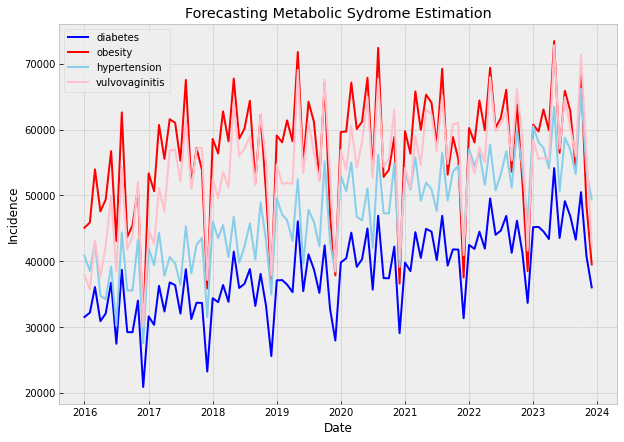

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(diabetes_forecast['ds'], diabetes_forecast['yhat'], 'b',label = 'diabetes')
plt.plot(obesity_forecast['ds'], obesity_forecast['yhat'], 'r', label = 'obesity')
plt.plot(hypertension_forecast['ds'], hypertension_forecast['yhat'], 'skyblue',label = 'hypertension')
plt.plot(vulvovaginitis_forecast['ds'], vulvovaginitis_forecast['yhat'], 'pink', label = 'vulvovaginitis')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Incidence')
plt.title('Forecasting Metabolic Sydrome Estimation');

The figure above is the plot of four forecastings merged, and it seems that the trend is similar to increase constantly. The seasonality, as was mention before, is uniform, with the smoothed peaks in January representing a good prediction of the future besides the changes with the Covid-19 pandemia and new policies of the Mexican government. According to the Mexican government, metabolic syndrome is the seven to the ten causes of morbidity in 2019 but one of the first places in mortality [8]. That is why other people try to do similar work with available data. 


##Related Work
Soto-Estrada, J. [9] presents an epidemiological overview of Mexico, analyzing the leading causes of morbidity and mortality. Both models agree that infections are the prevalent cause of morbidity in Mexico and require continuing to control them. Likewise, create new strategies to reduce incidence in the non-infectious diseases that are becoming the predominant causes of death in Mexico. Unfortunately, models can not be compared because Soto-Estrada, J. does not show forecasting and validation of his model.

Gutiérrez-Solis, A. L. et al. [10] retrieved 15 articles in a systematic review, and all of them declare that metabolic syndrome in Mexico has a high prevalence. They recommend that Mexico urgent need to control and prevent metabolic syndrome and its complications. Since it is a review, there is not a model of comparison. Still, the conclusion is similar to the purpose of this forecasting: preventent the metabolic syndrome in the early stages when it is cheaper for the government and the Mexican families.

Rivas-Gomez, B., et al. [11] performed exploratory analysis for dyslipidemia that cause obesity and suggest that dyslipidemia has a notable role in decreasing the number of preventable deaths caused by non-communicable diseases. Moreover, the forecasting establishes the same position since obesity has a greater incidence, and its growth seems to precede the other two comorbidities and boost the fourth one.

Bello-Chavolla, O. Y., et al. [12] study the National Health Survey in Mexico classifing their results according to the age and suggest stratified according etnicies, create public electronic health records to analize more information and not only prevalences with out features of the patients.They also mention that the Mexican government has implemented several initiatives to reduce the population's exposure to calorie-dense products. These include taxes and regulation of the media. The impact of the previous interventions was being evaluated at their moment. Now the trend continues to grow to evidence that they were ineffective.


##Conclusions
The forecasting of relevant morbidities in Mexico is accurate applying time series analysis. The estimation will be helpful for the government to create policies for the country taking care of their population. Infectious diseases are the most common cause of morbidity plot in the clusters, so they required a plan to control them in the same way as now or even better. 

Since Metabolic Syndrome conditions are the seven to the ten causes of morbidity in Mexico, and they are incurable but preventable. Therefore, they required the creation of new policies to reduce incidences. According to Forbes Mexico [13] and citing the country's government, the last one is the latest labeling that in five years reduce 13 million obesity cases representing 1,800 million pesos in savings of the public health budget.

 These trials represent the future work analyzing the accurate data from these new years and the forecasting done with the Facebook Prophet, demonstrating their efficiency that has not been seen for the previous policies since the trend continues to grow.  In the past, incidence trends did not change because they only are achieved if the people learn how to take care of their health and change their lifestyle style, including physical activity and healty feed habits.  

####Future Work
The data available is to 2019, so the future work will be to deal with the change in actual data for 2020 and 2021 and update the forecasting. It will have two causes of noise, one of them negatively and hopefully the other positively. The first one is the pandemic. Since most people stay at home, the doctor does not focus on the chronic conditions reducing the incidence count. But, on the other hand, patients do not take care to be over control, eat more to stay at home, and eliminate the possibility of training in gyms and public gardens, raising the number of obese, diabetics, and hypertensive. The second is the original cause, the people who have worse eating habits combined with low or null training, and in an attempt to reduce the trends of the syndrome and change these habits, the government generates health policies. The last try is the new labeling of product which need to say if they are excessive in a specific nutrient. The leading labels are excess sugar or fat, high levels of calories, and surfeit of salt. 

##References
[1] F. Provost and T. Fawcett, Data science for business: what you need toknow about data mining and data-analytic thinking. O’Reilly, 2013.

[2] https://www.oecd.org/centrodemexico/medios/Gasto%20P%C3%BAblico%20Social%20OCDE.pdf

[3] http://www.conamed.gob.mx/gobmx/boletin/pdf/boletin19/financiamiento_salud.pdf

[4] http://www.diputados.gob.mx/sedia/sia/se/SAE-ISS-12-20.pdf

[5] https://www.gob.mx/salud/acciones-y-programas/direccion-general-de-epidemiologia-boletin-epidemiologico#:~:text=El%20Bolet%C3%ADnEpidemiol%C3%B3gico%20Sistema%20Nacional%20de,la%20Direcci%C3%B3n%20General%20de%20Epidemiolog%C3%ADa.

[6] Ventolini, G., Khandelwal, N., Hutton, K., Lugo, J., Gygax, S. E., & Schlabritz-Loutsevitch, N. (2017). Obesity and recurrent vulvovaginal bacterial infections in women of reproductive age. Postgraduate medical journal, 93(1099), 297. https://doi.org/10.1136/postgradmedj-2016-134638

[7] https://www.mayoclinic.org/diseases-conditions/obesity/diagnosis-treatment/drc-20375749

[8] https://epidemiologia.salud.gob.mx/anuario/html/anuarios.html

[9] Soto-Estrada, Guadalupe, Moreno-Altamirano, Laura, & Pahua Díaz, Daniel. (2016). Panorama epidemiológico de México, principales causas de morbilidad y mortalidad. Revista de la Facultad de Medicina (México), 59(6), 8-22. Recuperado en 02 de junio de 2021, de http://www.scielo.org.mx/scielo.php?script=sci_arttext&pid=S0026-17422016000600008&lng=es&tlng=es.

[10] Gutiérrez-Solis, A. L., Datta Banik, S., & Méndez-González, R. M. (2018). Prevalence of Metabolic Syndrome in Mexico: A Systematic Review and Meta-Analysis. Metabolic syndrome and related disorders, 16(8), 395–405. https://doi.org/10.1089/met.2017.0157

[11] Rivas-Gomez, B., Almeda-Valdés, P., Tussié-Luna, M. T., & Aguilar-Salinas, C. A. (2018). DYSLIPIDEMIA IN MEXICO, A CALL FOR ACTION. Revista de investigacion clinica; organo del Hospital de Enfermedades de la Nutricion, 70(5), 211–216. https://doi.org/10.24875/RIC.18002573

[12] Bello-Chavolla, O. Y., Rojas-Martinez, R., Aguilar-Salinas, C. A., & Hernández-Avila, M. (2017). Epidemiology of diabetes mellitus in Mexico. Nutrition reviews, 75(suppl 1), 4–12. https://doi.org/10.1093/nutrit/nuw030

[13] https://www.forbes.com.mx/etiquetado-reduciria-en-cinco-anos-1-3-millones-de-casos-de-obesidad-en-mexico/?utm_source=nora-push&utm_medium=push-notifications&utm_campaign=new-nora-push
